<a href="https://colab.research.google.com/github/Mohak91/Course-on-comparative-genomics-of-bacteria/blob/main/Lab_practical_session_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/comp_gen_bacteria_krea

/content/drive/MyDrive/comp_gen_bacteria_krea


In [ ]:
FNA="/content/drive/MyDrive/comp_gen_bacteria_krea/GCF_000027325.1_ASM2732v1_genomic.fna"

In [ ]:
def extract_genome_sequence(FNA):
  sequence=""
  with open(FNA) as fh:
    for line in fh:
      if not line.startswith(">"):
        sequence+=line.rstrip("\n")
  return sequence

In [ ]:
genome_sequence=extract_genome_sequence(FNA)
genome_sequence

For nucleotides,

Shannon Entropy = Probability(A) * log4(1/ Probability(A)) + Probability(T) * log4(1/ Probability(T)) + Probability(G) * log4(1/ Probability(G)) + Probability(C) * log4(1/ Probability(C))

or 

Shannon Entropy = Probability(A) * Surprise(A) + Probability(T) * Surprise(T) + Probability(G) * Surprise(G) + Probability(C) * Surprise(C)



In [ ]:
#adding the products of all nucleotides for their probability and surprise
#base freq = probability 
#surprise=log4(1/prob(nt))

import math

def shannon_entropy(sequence_string):

  basecount={"A":1,"T":1,"G":1,"C":1} #pseudocounts

  for base in sequence_string:
    basecount[base]+=1

  total=float(sum(basecount.values())) #total number of nucleotides = length of the genome
  base_freq= [basecount[nt]/total for nt in basecount] #list comprehension

  shannon_entropy=0.0
  for bf in base_freq:
    shannon_entropy += bf * math.log(bf,4)
  shannon_entropy = -1.0*shannon_entropy
  return shannon_entropy

In [ ]:
shannon_entropy_global = shannon_entropy(genome_sequence)

In [ ]:
print(shannon_entropy_global) #shannon entropy for the entire sequence

0.9504455806237782


  Let's calculate the Shannon Entropy for all residues across the genome, in a context of 20 bps with overlapping windows.

Let's say this is the region:

ATGTGCATGCATGCTACGTACGTACGC

At 11th position, there is an A, so we take ten nucleotides before it and ten nucleotides after it to call it one region and calculate the entropy for the entire region of 21 bps:

*ATGTGCATGC* A *TGCTACGTAC* GTACGC

At 12th position, there is an A, so we take A, ten nucleotides before it and ten nucleotides after it to call it one region and calculate the entropy for the entire region of 21 bps:

A *TGTGCATGCA* T *GCTACGTACG* TACGC

What about regions before the 11th position?
And similarly, as you reach the end of the genome, you can only go uptil the point where window size = 10 ( to give a total of 21 bp region) could be accomodated.

In [ ]:
genome_sequence_list=list(genome_sequence)
#AAAAAAAAA TTTTTTTTTTTGGGGGGGGGGGGGG
#list slicing
#0123456789.............
shannon_entropy_list_local_genome_regions=[]
window_size=10 #10 base pair left of a given position and 10 base pairs right of a given position + the nucleotide position around which the windows are extended = 21 length
for position in range(0,len(genome_sequence_list)-window_size+1):
  wstart=max(0,position-window_size)
  wend=min(len(genome_sequence_list),position+window_size+1)
  seq_region=genome_sequence_list[wstart:wend]
  seq_region_string="".join(seq_region)
  #print(seq_region_string)
  #print(shannon_entropy(seq_region_string))
  shannon_entropy_list_local_genome_regions.append(shannon_entropy(seq_region_string))

In [ ]:
len(shannon_entropy_list_local_genome_regions) #entropy values for all positions in the genome # remember these are overlapping windows

580067

In [ ]:
window_list=[]
for i in range(len(shannon_entropy_list_local_genome_regions)):
  window_list.append(i+1)

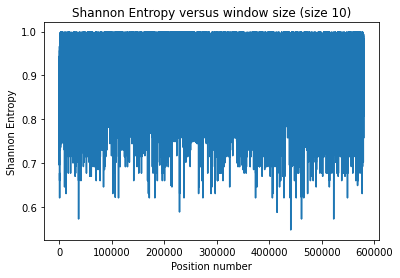

In [ ]:
import matplotlib.pyplot as plt

plt.plot(window_list,shannon_entropy_list_local_genome_regions)
plt.title("Shannon Entropy versus window size (size 10)")
plt.xlabel("Position number")
plt.ylabel("Shannon Entropy")
plt.show()

Let's only plot those positions that fall in regions with entropy (average surprise) less than three standard deviations below the average entropy (average of average surprise).

In [ ]:
import numpy as np
SEarr = np.array(shannon_entropy_list_local_genome_regions)#converting to a numpy array
average = np.mean(SEarr) #finding the mean of the numpy array created above, using the command np.mean()
std = np.std(SEarr) ##finding the standard deviation of the numpy array created above, using the command np.mean()
cutoff = 3*std #setting a cut-off of three standard deviations

potential_low_complexity_regions=[]
potential_low_complexity_regions_window=[]

for i in range(len(shannon_entropy_list_local_genome_regions)):
  if shannon_entropy_list_local_genome_regions[i] < average-cutoff:
    potential_low_complexity_regions.append(shannon_entropy_list_local_genome_regions[i])
    potential_low_complexity_regions_window.append(i+1)

In [ ]:
len(potential_low_complexity_regions)

6562

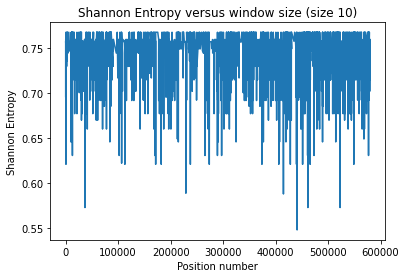

In [ ]:
import matplotlib.pyplot as plt

plt.plot(potential_low_complexity_regions_window,potential_low_complexity_regions)
plt.title("Shannon Entropy versus window size (size 10)")
plt.xlabel("Position number")
plt.ylabel("Shannon Entropy")
plt.show()

Can you calculate the entropy for all non-overlapping regions in the M. genitalium genome? One region should be of length 20 bps.

For example,

genome= "ATGTGCATGCATGCTACGTACGTACGC"

If I split the above "genome" into non-overlapping regions of size 4 each, I will get the following regions:

ATGT GCAT GCAT GCTA CGTA CGTA CGC

Note how last region ended up with just three nucleotides.